<img src="../imgs/MLU.jpg" style="width:1000px;">

# <center> 05. Understanding Machine learning! </center>

In [2]:
from sklearn.datasets import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from sklearn.metrics import *
%matplotlib inline
%run -i ../code/utils.py

Graphviz already installed


# Observe the classification boundaries generated different classifiers

we are using a toy dataset, it is **generated everytime**

- change the `max_deph` on the decision tree to 1, to 3 or more and observe the decision tree it is generated
- change the kernel, degree and gamma parameter of the SVC.

see **help** on each estimators to see available parameters

0.07s
0.05s
0.68s


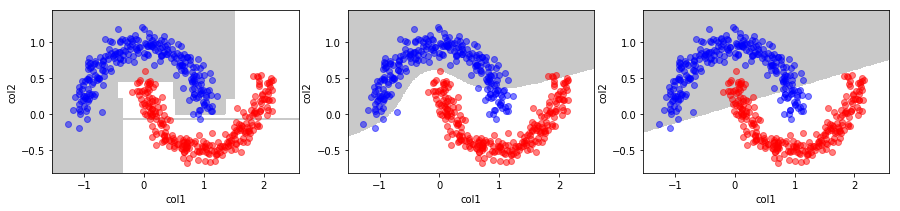

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time

dt = DecisionTreeClassifier(max_depth=5)
sv = SVC(kernel="poly",  degree=3, gamma=2)
lr = LogisticRegression()

estimators = [ dt, sv, lr ]

X,y = make_moons(500, noise=0.1)

plt.figure(figsize=(15,3))
for i, estimator in enumerate(estimators):
    plt.subplot(1,3,i+1)
    t0 = time.time()
    estimator.fit(X,y)
    plot_2Ddata_with_boundary(estimator.predict, X,y)
    t1 = time.time()
    print( ('%.2fs' % (t1 - t0)))
    plt.xlabel("col1"); plt.ylabel("col2")
    

# Understand the boundaries of each method

## Decision Tree Classifier

In [4]:
print "coefs", lr.coef_

coefs [[ 1.14812992 -4.63760346]]


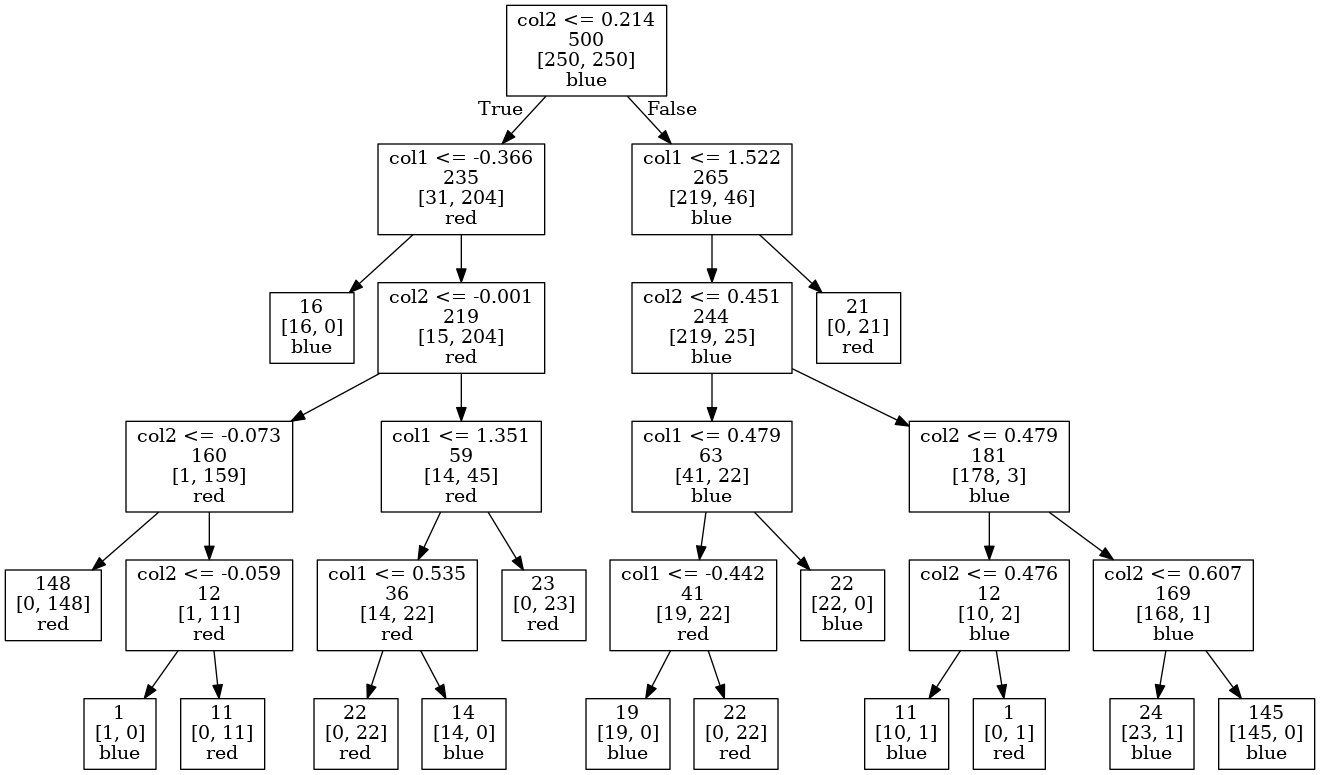

In [5]:
visualize_tree(dt, ["col1", "col2"])
Image("/tmp/dt.png", width=200)

## Support Vector Machine

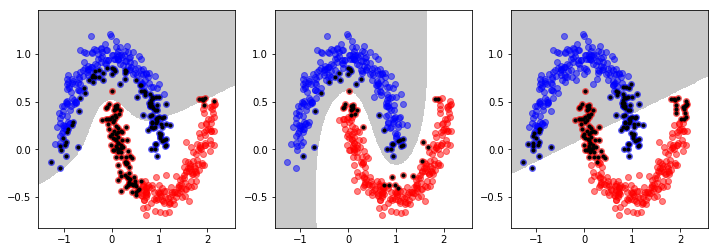

In [6]:
plt.figure(figsize=(12,4))
sv1 = SVC(kernel="poly",  degree=3, gamma=0.5)
sv2 = SVC(kernel="rbf",  gamma=1)
sv3 = SVC(kernel="linear", gamma=1)
for i,sv in enumerate([sv1, sv2, sv3]):
    plt.subplot(1,3,i+1)
    sv.fit(X,y)
    plot_2Ddata_with_boundary(sv.predict, X,y)
    plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], color="black", s=10, alpha=1.)


# Overfitting

let's supose now we have a noisier dataset. 

- what would be the "natural" classification boundary for this dataset?
- what accuracy would you expect to get?

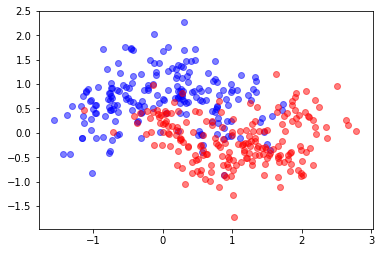

In [7]:
X,y = make_moons(400, noise=0.4)
plot_2Ddata_with_boundary(None, X,y)

we now use a 50/50 random split to train and to test

In [8]:
def plot_train_test(estimator, Xtr, Xts, ytr, yts, alpha=.5):
    estimator.fit(Xtr,ytr)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_2Ddata_with_boundary(estimator.predict, Xtr,ytr, alpha=alpha)
    plt.title("TRAIN accuracy %.3f"%estimator.score(Xtr, ytr))
    plt.subplot(122)
    plot_2Ddata_with_boundary(estimator.predict, Xts,yts, alpha=alpha)
    plt.title("TEST accuracy %.3f"%estimator.score(Xts, yts))


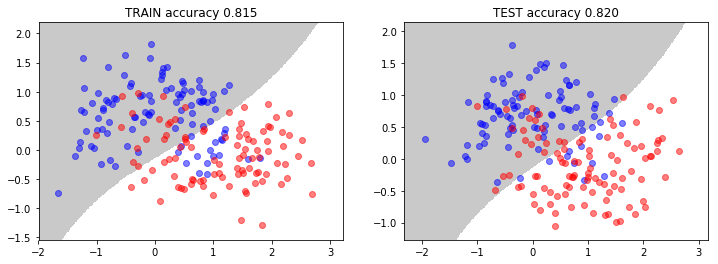

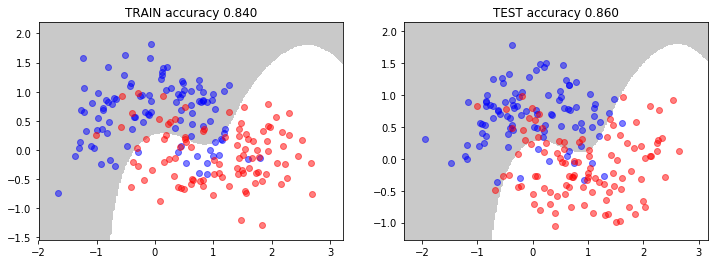

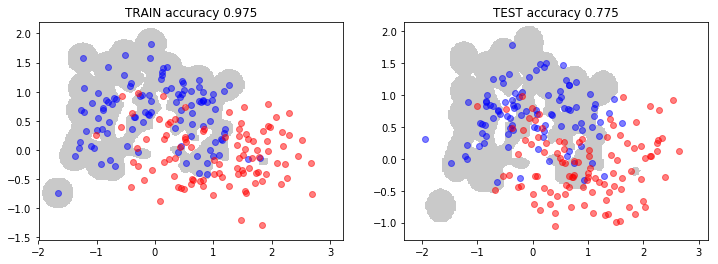

In [9]:
from sklearn.model_selection import train_test_split
X,y = make_moons(400, noise=0.4)
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.5)

plot_train_test(SVC(kernel="rbf",  gamma=.1), Xtr, Xts, ytr, yts)
plot_train_test(SVC(kernel="rbf",  gamma=1), Xtr, Xts, ytr, yts)
plot_train_test(SVC(kernel="rbf",  gamma=100), Xtr, Xts, ytr, yts)


# Real data example

a decision tree also gives us a measure on feature importance. let's keep the first two features which are the most important ones and we can thus represent 2D boundaries.

In [14]:
d = pd.read_csv("../data/data_banknote_authentication.txt.gz")
dt = DecisionTreeClassifier(max_depth=5)
X = d.values[:,:-1]
y = d.values[:,-1]
dt.fit(X,y)
print dt.score(X,y)
dt.feature_importances_

0.983965014577


array([ 0.60337463,  0.242166  ,  0.13676398,  0.01769539])

In [15]:
from sklearn.ensemble import RandomForestClassifier
dt =DecisionTreeClassifier()#SVC()#RandomForestClassifier()

X = d.values[:,:2]
y = d.values[:,-1]

Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.5)

dt.fit(Xtr,ytr)
print dt.score(Xts,yts)

0.927113702624


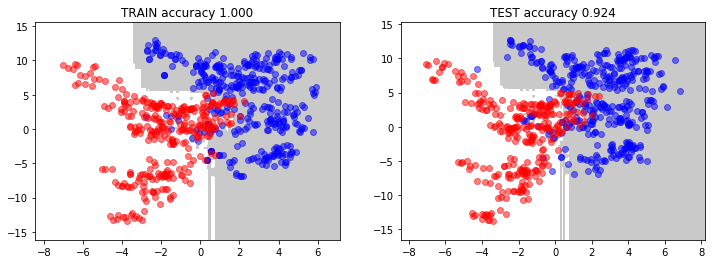

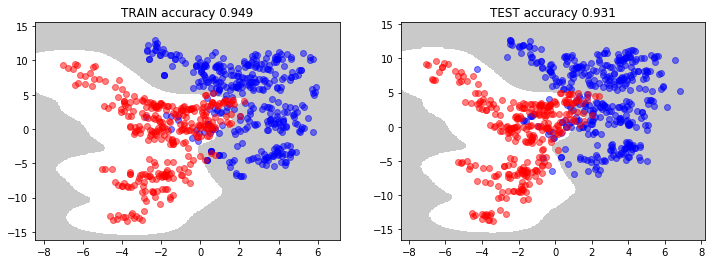

In [16]:
from sklearn.ensemble import RandomForestClassifier
X = d.values[:,:2]
y = d.values[:,-1]
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.5)
plot_train_test(RandomForestClassifier(), Xtr, Xts, ytr, yts, alpha=.5)
plot_train_test(SVC(), Xtr, Xts, ytr, yts, alpha=.5)


# Preprocessing

recall that GaussianNB did not perform so well from previous notes.

In [13]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold

d = pd.read_csv("../data/data_banknote_authentication.txt.gz")
X = d.values[:,:-1]
y = d.values[:,-1]
print "X shape", X.shape
s = cross_val_score(GaussianNB(), X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s))

X shape (1372, 4)
accuracy 0.839 (+/- 0.01985)


we preprocess our dataset with PCA

## PCA

<img src="../imgs/PCA.png" style="width:700px;">


In [78]:
X = d.values[:,:-1]
X = PCA(n_components=3).fit_transform(X)
print "shape after PCA ", X.shape
s = cross_val_score(GaussianNB(), X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s))

shape after PCA  (1372, 3)
accuracy 0.969 (+/- 0.01500)


# Pipelines

we are somehow cheating, since PCA is computed with all data

In [13]:
from sklearn.pipeline import Pipeline

Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.5)

p = Pipeline((("pca", PCA(n_components=3)), ("classifier", GaussianNB()) ))

p.fit(Xtr, ytr)

print "TRAIN accuracy %.3f"%p.score(Xtr, ytr)
print "TEST  accuracy %.3f"%p.score(Xts, yts)

TRAIN accuracy 0.968
TEST  accuracy 0.968


now with cross validation

In [14]:
s = cross_val_score(p, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s))

accuracy 0.967 (+/- 0.01539)


# <span style="color:orange"> 1. student</span>: 

1. Try overfitting in other classification problem
2. How is the overfitting in bike regression dataset?. Try changing different parameteres
3. In pipeline adding quadratic features. What happenend?


---
# <center> Thanks! </center>